# Tweet Sentiment Analysis
## Introduction
In today's digital landscape, social media platforms like Twitter have become major channels for public discourse. However, the vast amount of content generated can be overwhelming, making it challenging to gauge the general sentiment on various topics. This project aims to address this challenge by applying machine learning techniques to analyze the sentiment of tweets.

This notebook documents the process of building and comparing several machine learning models to accurately classify tweets as expressing positive, negative, or neutral sentiment. This project encompasses data loading, preprocessing, exploratory data analysis (EDA), model training and validation, and a final comparative analysis to select the most effective model for tweet sentiment analysis.

## Loading and Preprocessing Data

In [124]:
# import necessary libraries for data manipulation, models building and training, and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import download
from tqdm import tqdm
import seaborn as sns
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.phrases import Phrases
from gensim.models import FastText
import joblib
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # if needed, download NLTK data
# download('punkt') # tokenizers
# download('wordnet') # database for lemmatization
# download('stopwords') # list of stopwords

## Data Preparation
This dataset consists of 1.6 million tweets, each with a rating of 0 – meaning negative – or 4 – meaning positive.

The data prep phase is crucial as it sets the foundation for the modeling process. We start by loading our datasets: one containing verified fake news articles, and another containing real news. Each dataset consists of features including the article title, text, subject, and date. For the scope of this classification project, we will focus on the textual content of each article.

Next, we will add a class label to differentiate the data points within each dataset, and then we will concatenate these datasets into a single dataframe and shuffle them to ensure a randomized distribution of 'false' and 'true' datapoints. These steps are essential to ensure the model is able to properly learn which features contribute to 'false' classification and which to 'true', and to prevent the model from learning and relying on any potential ordering in the data.

In [32]:
# load dataset
df_tweets = pd.read_csv('tweets.csv', encoding='latin', header=None)

In [33]:
# display first 5 rows of the dataset
df_tweets.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [34]:
# add header label to each column
df_tweets.columns = ['sentiment', 'id', 'date', 'query', 'author', 'tweet']
df_tweets.head()

,sentiment,id,date,query,author,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [35]:
# shuffle the dataset
df = df_tweets.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [36]:
# check for null/missing values
df.isnull().sum()

# we only care about the text for sentiment analysis
# drop all other other columns that exist in the dataset
columns_to_drop = ['id', 'date', 'query', 'author']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# change sentiment labels so 0 goes to 'negative' and 4 changes to 'positive'
df['sentiment'] = df['sentiment'].apply(lambda x: 'negative' if x == 0 else 'positive')

## Exploratory Data Analysis
Before diving into building and comparing models, it's crucial to understand the data itself. This section covers some basic EDA to visualize the distribution of the classes, check for any imbalances, and identify any initial trends or patterns that could inform our feature engineering and modeling strategy in the future.

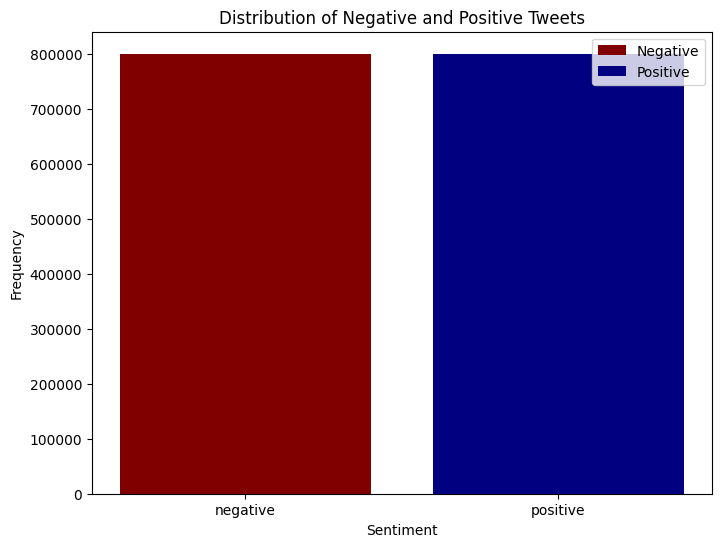

In [37]:
# get frequency of each class within the dataset
# set labels for each class: 0 is negative and 1 is positive
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = ['Negative', 'Positive']

# plot the distribution of the classes
plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['maroon', 'navy'])
plt.title('Distribution of Negative and Positive Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

# add a legend with custom colors
plt.legend(bars, sentiment_labels)
plt.show()

As we can see in our analysis, the distribution of sentiments is even, meaning no further adjustments are necessary for our dataset. It is important to have a balanced dataset because it means that models have equal ability to learn to classify data points into each category.

## Preprocessing
In this phase, we aim to clean and prepare our dataset for modeling. Given the project's focus on Natural Language Processing (NLP), our preprocessing involves several important steps:

1. **Normalization:** Convert all text data to lowercase.
2. **Cleaning:** Remove unnecessary spaces and and special character.
3. **Lemmatization:** Apply lemmatization to distill words down to their meaningful base forms. Unlike stemming, lemmatization considers the context and transforms words to their dictionary form, rather than simply shortening each word.
4. **Stopword Removal:** Remove stopwords – 'a', 'is', 'the', etc. – from the text. Since these words are so frequent in the English language, they typically carry little weight in NLP and can introduce noise into the model's learning process.
5. **Tokenization:** Segment text into a list of words. This step simplifies the handling of text data by breaking down lengthy strings into individual words, which are far more manageable. This leads to easier and more effective processing.

Through these steps, we aim to remove unnecessary noise and enhance the data's quality, which is instrumental in building robust models capable of accurately distinguishing between fake and real news.

In [38]:
# initialize tqdm for pandas apply function to track how long it takes to preprocess the text data
tqdm.pandas()

# create set of English stopwords
stop_words = set(stopwords.words('english'))
# additional_stopwords = {'reuters'} # adding words that are common but not relevant to text
# combined_stopwords = stop_words.union(additional_stopwords)

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower() # lowercase
    text = re.sub('\[.*?\]', '', text) # remove substrings in square brackets
    text = re.sub('https://\S+|www\.\S+', '', text) # remove urls
    text = re.sub('<.*?>+', '', text) # remove html tags
    text = re.sub('\\W', ' ', text) # remove non-word characters
    text = re.sub('\w*\d\w*', '', text) # remove words with numbers
    tokens = word_tokenize(text) # tokenize text
    tokens = [word for word in tokens if word not in stop_words] # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # lemmatization
    
    return ' '.join(tokens) # join processed tokens back into a string

In [39]:
df['tweet'] = df['tweet'].progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1600000/1600000 [02:23<00:00, 11147.01it/s]


In [40]:
df.head()

,sentiment,tweet
0,negative,chrishasboobs ahhh hope ok
1,negative,misstoriblack cool tweet apps razr
2,negative,tiannachaos know family drama lame hey next ti...
3,negative,school email open geography stuff revise stupi...
4,negative,upper airway problem


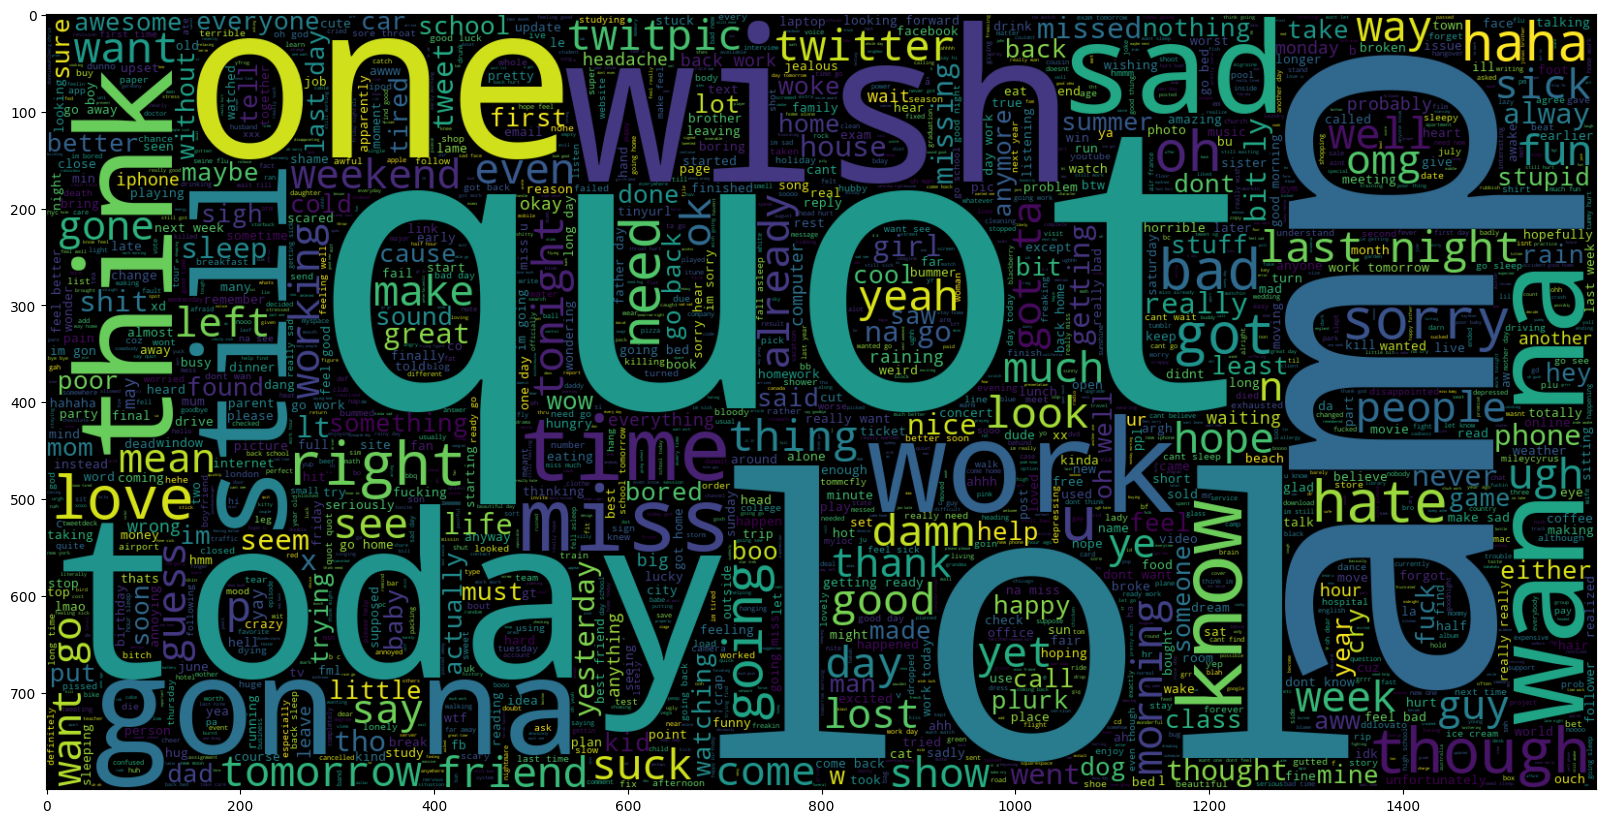

In [41]:
# negative tweets wordcloud
plt.figure(figsize=(20,20))
neg_wc = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(df[df.sentiment=='negative']['tweet']))
plt.imshow(neg_wc, interpolation='bilinear')

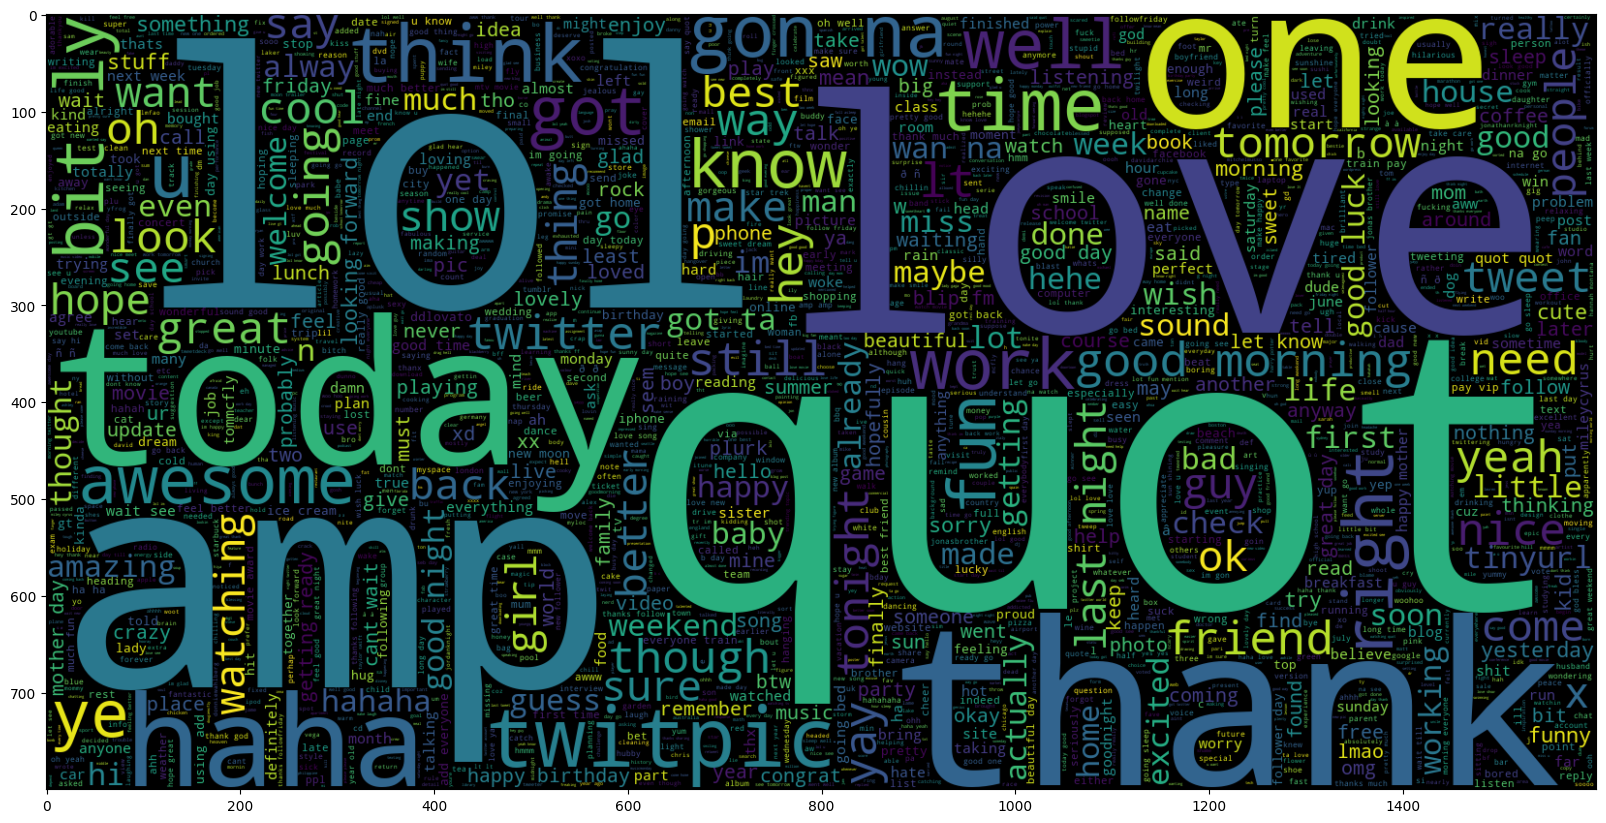

In [42]:
# positive tweets wordcloud
plt.figure(figsize=(20,20))
pos_wc = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(df[df.sentiment=='positive']['tweet']))
plt.imshow(pos_wc, interpolation='bilinear')

## Feature Engineering and Selection
For feature engineering, we must explore the dataset to identify the variables that contribute most to our models' decision-making process. Feature engineering is a crucial step in the machine learning pipeline as it involves creating new features or modifying existing ones to improve model performance. 

To begin with, we will vectorize our text data, which will convert the text into numerical data that our machine learning models are able to understand. To do so, we will use TF-IDF (Term Frequency-Inverse Document Frequency. TF-IDF is a statistical measure that evaluates the importance of a word in a document relative to an entire collection of documents. It takes two things into consideration:

1. **Term Frequency (TF):** The frequency of a word in a document.
2. **Inverse Document Frequency (IDF):** A measure that reduces the weight of words common across all documents.

The TF-IDF score is the product of TF and IDF, meaning words that are significant in a specific document but not commonly used in other documents will be weighted higher than words that are prevalent throughout many documents.

In [43]:
# initialize TF-IDF vectorizer and create X, our input feature matrix
# only top 5000 features, cannot be in more than 50% of docs, must be in at least 2 docs
vectorization = TfidfVectorizer(max_df=0.75, min_df=0.01, max_features=100_000)
X = vectorization.fit_transform(df['tweet'])

# shape of feature matrix
print(X.shape)

(1600000, 103)


Limiting the number of features during vectorization can have many added benefits. Not only does this reduce complexity, leading to simpler models that are faster to train and easier to interpret, but this also reduces noise further and means that less memory is requires to store this matrix. Setting a max_feature limit here means that our vectorizer is forced to focus on only the top 5000 words that are most prevalent across the dataset.

## Model Training
With our features selected and engineered, it's finally time to start training our models. For this project, we will start by comparing several machine learning models to see which performs best at classifying fake and real news.

Each model will be trained on the same training set, which will be a random sample of 70% of our entire dataset. Subsequently, we will evaluate their respective performances on a separate validation set, which accounts for 15% of the data, before making a final decision on the best model. The remaining unseen 15% of the dataset – our test set – will be used for the final evaluation of our selected model. The models we will train include Logistic Regression, Decision Trees, Gradient Boosting, and Random Forest. Will will track each model's accuracy and other performance metrics to determine which model is most effective for this project.

In [102]:
# set dependent variable y to class labels
y = df['sentiment']

# split data into traning, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [103]:
# confirm data is split properly
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1120000, 103) (240000, 103) (240000, 103)
(1120000,) (240000,) (240000,)


### Logistic Regression

In [104]:
# initialize logistic regression model
lr_model = LogisticRegression()

# train logistic regression model
lr_model.fit(X_train, y_train)

# predict on validation set
lr_pred = lr_model.predict(X_val)

# evaluate lr model using accuracy score and classification report
print(f'Accuracy: {accuracy_score(y_val, lr_pred)}\n')
print(f'Classification Report:\n {classification_report(y_val, lr_pred)}')

# save model using joblib
lr_path = 'LogisticRegression.joblib'
joblib.dump(lr_model, lr_path)

# calculate number of incorrect classifications using confusion matrix
cm_lr = confusion_matrix(y_val, lr_pred)
print(f'Confusion Matrix:\n {cm_lr}\n')

cm_lr_sum = cm_lr.sum()
cm_lr_correct = cm_lr.diagonal().sum()
cm_lr_incorrect = cm_lr_sum - cm_lr_correct
print(f'Number Incorrect Logistic Regression Classifications: {cm_lr_incorrect}')

Accuracy: 0.64955

Classification Report:
               precision    recall  f1-score   support

    negative       0.63      0.73      0.67    120186
    positive       0.68      0.57      0.62    119814

    accuracy                           0.65    240000
   macro avg       0.65      0.65      0.65    240000
weighted avg       0.65      0.65      0.65    240000

Confusion Matrix:
 [[87209 32977]
 [51131 68683]]

Number Incorrect Logistic Regression Classifications: 84108


### Decision Trees

In [105]:
# initialize decision tree model
dt_model = DecisionTreeClassifier()

# train dt model
dt_model.fit(X_train, y_train)

# predict on validation set
dt_pred = dt_model.predict(X_val)

# evaluate dt model using accuracy score and classification report
print(f'Accuracy: {accuracy_score(y_val, dt_pred)}\n')
print(f'Classification Report:\n {classification_report(y_val, dt_pred)}')

# save model using joblib
dt_path = 'DecisionTrees.joblib'
joblib.dump(dt_model, dt_path)

# calculate number of incorrect classifications using confusion matrix
cm_dt = confusion_matrix(y_val, dt_pred)
print(f'Confusion Matrix:\n {cm_dt}\n')

cm_dt_sum = cm_dt.sum()
cm_dt_correct = cm_dt.diagonal().sum()
cm_dt_incorrect = cm_dt_sum - cm_dt_correct
print(f'Number Incorrect Decision Tree Classifications: {cm_dt_incorrect}')

Accuracy: 0.6317166666666667

Classification Report:
               precision    recall  f1-score   support

    negative       0.61      0.72      0.66    120186
    positive       0.66      0.54      0.59    119814

    accuracy                           0.63    240000
   macro avg       0.64      0.63      0.63    240000
weighted avg       0.64      0.63      0.63    240000

Confusion Matrix:
 [[86849 33337]
 [55051 64763]]

Number Incorrect Decision Tree Classifications: 88388


## Gradient Boosting

In [106]:
# initialize gradient boost model
gb_model = GradientBoostingClassifier(random_state=42)

# train gb model
gb_model.fit(X_train, y_train)

# predict on validation set
gb_pred = gb_model.predict(X_val)

# evaluate gb model using accuracy score and classification report
print(f'Accuracy: {accuracy_score(y_val, gb_pred)}\n')
print(f'Classification Report:\n {classification_report(y_val, gb_pred)}')

# save model using joblib
gb_path = 'GradientBoosting.joblib'
joblib.dump(gb_model, gb_path)

# calculate number of incorrect classifications using confusion matrix
cm_gb = confusion_matrix(y_val, gb_pred)
print(f'Confusion Matrix:\n {cm_gb}\n')

cm_gb_sum = cm_gb.sum()
cm_gb_correct = cm_gb.diagonal().sum()
cm_gb_incorrect = cm_gb_sum - cm_gb_correct
print(f'Number Incorrect Gradient Boost Classifications: {cm_gb_incorrect}')

Accuracy: 0.635725

Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.83      0.70    120186
    positive       0.72      0.44      0.54    119814

    accuracy                           0.64    240000
   macro avg       0.66      0.64      0.62    240000
weighted avg       0.66      0.64      0.62    240000

Confusion Matrix:
 [[100278  19908]
 [ 67518  52296]]

Number Incorrect Gradient Boost Classifications: 87426


## Random Forest

In [107]:
# initialize random forest model
rf_model = RandomForestClassifier(random_state=42)

# train rf model
rf_model.fit(X_train, y_train)

# predict on validation set
rf_pred = rf_model.predict(X_val)

# evaluate rf model using accuracy score and classification report
print(f'Accuracy: {accuracy_score(y_val, rf_pred)}\n')
print(f'Classification Report:\n {classification_report(y_val, rf_pred)}')

# save model using joblib
rf_path = 'RandomForest.joblib'
joblib.dump(rf_model, rf_path)

# calculate number of incorrect classifications using confusion matrix
cm_rf = confusion_matrix(y_val, rf_pred)
print(f'Confusion Matrix:\n {cm_rf}\n')

cm_rf_sum = cm_rf.sum()
cm_rf_correct = cm_rf.diagonal().sum()
cm_rf_incorrect = cm_rf_sum - cm_rf_correct
print(f'Number Incorrect Random Forest Classifications: {cm_rf_incorrect}')

Accuracy: 0.6468375

Classification Report:
               precision    recall  f1-score   support

    negative       0.63      0.73      0.67    120186
    positive       0.68      0.56      0.61    119814

    accuracy                           0.65    240000
   macro avg       0.65      0.65      0.64    240000
weighted avg       0.65      0.65      0.64    240000

Confusion Matrix:
 [[87643 32543]
 [52216 67598]]

Number Incorrect Random Forest Classifications: 84759


## Deep Learning
### Preprocessing
Most deep learning algorithms don't understand natural languages, meaning it is necessary to first transform that text data into numerical data.

In [114]:
# set dependent variable y to class labels
y = df['sentiment']

# split data into traning, validation, and test sets
train_data, temp_data = train_test_split(df, test_size=0.30, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

X_train = train_data['tweet']
y_train = train_data['sentiment']

X_val = val_data['tweet']
y_val = val_data['sentiment']

X_test = test_data['tweet']
y_test = test_data['sentiment']

# confirm data is split properly
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1120000,) (240000,) (240000,)
(1120000,) (240000,) (240000,)


In [116]:
# set max number of unique words in tokenizer's vocabulary
max_nb_words = 100_000

# initialize keras tokenizer; only looking at top 100_000 most common words
tokenizer = Tokenizer(num_words=max_nb_words)

# fit tokenizer on text data to build word index (mapping from words to integers)
tokenizer.fit_on_texts(df['tweet'])

# convert text data to sequences of integers
# each integer corresponds to the index of a word in the tokenizer's vocabulary
X_sequences = tokenizer.texts_to_sequences(df['tweet'])

# set max length of sequences, pad the rest so they all have the same length
max_seq_len = max(len(sequence) for sequence in X_sequences) # want max length of all sequences, not just train data
print(f'Maximum sequence length: {max_seq_len}')

# get word index from tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f'Length of tokenizer vocabulary: {vocab_size}')

# pad sequences less than max_seq_len to get a uniform length for input shape for the sequence
# texts_to_sequences converts text sequences in training data into sequences of numerical indices using fitted tokenizer
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_seq_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_seq_len)
print(f'X shape: {X.shape}')

Maximum sequence length: 120
Length of tokenizer vocabulary: 527334
X shape: (1600000, 103)


In [117]:
print(np.unique(y_train))

['negative' 'positive']


In [118]:
# create list of labels
labels = df['sentiment'].unique().tolist()

# initializer label encoder
encoder = LabelEncoder()
encoder.fit(labels)

# convert labels to string and then transform to numerical format
y_train = encoder.transform(y_train.astype(str).tolist())
y_val = encoder.transform(y_val.astype(str).tolist())
y_test = encoder.transform(y_test.astype(str).tolist())

# reshape labels to match expected format
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(y_train.shape, y_val.shape, y_test.shape)

(1120000, 1) (240000, 1) (240000, 1)


Notice how now the unique values within y_train are 0 and 1, whereas before they were 'negative' and 'positive'

In [119]:
print(np.unique(y_train))

[0 1]


### Word Embedding with FastText

Word embedding is a technique used in NLP to represent words as dense vectors in a continuous vector space. Unlike other forms of representation, such as one-hot encoded vectors (where each word is represented as a unique vector with a value of 1 in its corresponding position and 0s everywhere else), word embeddings capture the semantic relationships between words. Words with similar meanings or used in similar contexts are represented by vectors that are closer together in the vector space.

Several popular algorithms are used to learn these embeddings from large collections of text, analyzing the contexts of each word to position them in a way that reflects their semantic relationships. One of the pioneering algorithms in this field is Word2Vec, developed by a team at Google. Word2Vec uses neural networks to learn word embeddings and has significantly influenced the development of subsequent embedding techniques.

For this project, we are using FastText, a technique for word embedding developed by Facebook's AI Research lab. FastText builds on the principles of Word2Vec but extends them further by representing words as combinations of their subwords or character n-gram sequences. This allows FastText to generate embeddings for unseen words based on their subword components, making it particularly well-suited for corpora such as tweets, which often contain out-of-vocabulary (OOV) words due to Twitter's informal, dynamic, and often multilingual language.

FastText's approach is not only incredibly efficient in terms of memory and computational speed but also effective in capturing the nuances of the vocabulary and slang used throughout Twitter. Its adaptability to different languages and proficiency in dealing with rare words make FastText an ideal choice for analyzing the sentiment of tweets in this project.

In [82]:
# extract familiar phrases and the most meaningful n-grams from our dataset
sent = [row.split() for row in df['tweet']]
phrases = Phrases(sent, min_count=30, progress_per=10_000)
sentences = phrases[sent]

# initialize FastText model
# window: window size for character n-grams that are considered before and after the target word
# min_count: minimum number of word occurances allowed
# min_n: min length of n-gram
# max_n: max length of n-gram
ft_model = FastText(vector_size=100, window=5, min_count=5, workers=4, min_n=1, max_n=4)

# building vocabulary
ft_model.build_vocab(sentences)
ft_vocabulary = ft_model.wv.key_to_index.keys()
print(len(ft_vocabulary))

74407


In [83]:
# train FastText model
ft_model.train(sentences, total_examples=len(sentences), epochs=100)

# save model using joblib
ft_path = 'FastText.joblib'
joblib.dump(ft_model, ft_path)

['FastText.joblib']

In [108]:
# function to see how many times a word of interest appears within the twitter dataset
def count_word_occurrences(sentences, word_to_count):
    count = sum(sentence.count(word_to_count) for sentence in sentences)
    return count

# user input for target word
target_word = str(input('Enter target word: '))

# print target word occurances
occurrences = count_word_occurrences(sent, target_word)
print(f"\nThe word '{target_word}' appears {occurrences} times in the dataset.\n")

# find 10 most similar words to inputted target word
print(f'The most similar words to {target_word} are:') 
ft_model.wv.most_similar(target_word, topn=10)

Enter target word:  torch



The word 'torch' appears 40 times in the dataset.

The most similar words to torch are:


[('torcher', 0.896856427192688),
 ('orch', 0.891009509563446),
 ('torchwood', 0.8625703454017639),
 ('porchester', 0.838762104511261),
 ('dorchester', 0.8287262916564941),
 ('porch', 0.8164301514625549),
 ('backyardigans', 0.8065162301063538),
 ('torrance', 0.8058957457542419),
 ('tort', 0.8011227250099182),
 ('orchard', 0.8002389669418335)]

### Neural Net
For this project, our deep learning model for sentiment analysis will use a Long Short-Term Memory (LSTM) architecture. This is a type of recurrent neural network (RNN) that is well-suited for sequential data processing. RNNs can maintain internal memory, making them ideal for tasks like this, where understanding the sequence of words is crucial. Our model consists of an embedding layer, an LSTM layer, and a dense output layer. The embedding layer transforms tokenized words into dense vectors, capturing semantic relationships. The LSTM layer processes these embeddings, maintaining information across the sequence. The output layer, a fully connected layer, maps the LSTM's output to the final prediction.

For the loss function, we're going to use Binary Cross-Entropy with Logits Loss, which is suitable for binary classification, and the Adam optimizer for its efficiency and adaptive learning rate properties. The goal is to select our hyperparameters to most effectively learn from the tweet data and make accurate sentiment predictions.

In [122]:
# set parameters
# batch_size: size of chunks of data in DataLoader
# epochs: number of times model iterates over the entire dataset
# learning_rate: step size at each epoch while moving towards a min of the loss function
# embedding_dimensions: size of embedding vector
# hidden_dimensions: size of hidden layer in LSTM
# vocab_size: should be len of the input word list from tokenizer, not vocab list from FastText model
batch_size = 64
epochs = 10
learning_rate = 0.001 
embedding_dimension = ft_model.wv.vector_size # will be 100 here – should be the same as the vector_size in the FastText model above
hidden_dimension = 128
input_vocab_size = len(tokenizer.word_index) + 1

# get indices in embedding matrix for each word in tokenizer's vocab
word_indices = [i for word, i in tokenizer.word_index.items() if word in ft_model.wv]
# extract corresponding FastText vectors for the words
embedding_vectors = [ft_model.wv[word] for word, i in tokenizer.word_index.items() if word in ft_model.wv]
# assign vectors to appropriate rows in embedding matrix
embedding_matrix[word_indices] = embedding_vectors

# convert data to PyTorch tensors
# check if X_train is sparse matrix -> if yes, convert to dense array before converting to tensor
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.long) if hasattr(X_train, 'toarray') else torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32) # don't need to check if sparse, since labels are usually dense
# check if X_val is sparse matrix -> if yes, convert to dense array before converting to tensor
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.long) if hasattr(X_val, 'toarray') else torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# create dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# load data in batches with DataLoader
# shuffling for training data ensures model doesn't learn connections based on the order of the data
# don't need to shuffle for validation data since no longer training, just validating/testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [126]:
# model architecture
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_weights):
        super(SentimentModel, self).__init__()

        # enbedding layer to convert word indices into dence vectors w a fixed size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # initialize pre-trained embedding weights
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32))
        # freeze the embeddings so that they aren't being updated during training
        self.embedding.weight.requires_grad = False

        # LSTM layer for processing the sequences of vectors
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # dense layer (fully connected) for the output predictions
        self.dense = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # forward pass through the neural net
        x = self.embedding(x)
        x, (hidden, _) = self.lstm(x)
        x = self.dense(hidden[-1]) # takes the last hidden state for the dense layer
        return x

# set up model
nn_model = SentimentModel(vocab_size, embedding_dimension, hidden_dimension, embedding_weights=embedding_matrix)

# set up loss function, optimizer, and scheduler
loss_function = nn.BCEWithLogitsLoss() # for binary classification
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # to update the embedding weights
# set up ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# evaluate function
def evaluate(nn_model, val_loader):
    # switch model into eval mode
    nn_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    # no gradient calculation since we're evaluating, not training
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = nn_model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs)) # converts the raw predictions into our binary (0 -> negative, 1 -> positive)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = val_loss/len(val_loader)
    accuracy = correct/total
    return avg_loss, accuracy

# training loop
for epoch in range(epochs):
    # put model in training mode
    nn_model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad() # reset the gradients
        outputs = nn_model(inputs) # forward pass through the model -> predict outputs
        loss = loss_function(outputs, targets) # calculate the loss for each epoch
        loss.backward() # backward pass -> calculate gradients to update model params and try to reduce loss
        # update params
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs} Loss: {avg_epoch_loss}')

    # evaluate model
    val_loss, val_accuracy = evaluate(nn_model, val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    scheduler.step(val_loss)

# save model
nn_path = 'NeuralNet.pth'
torch.save(nn_model.state_dict(), nn_path)

Epoch 1/10 Loss: 0.45986842294079916
Validation Loss: 0.4488, Validation Accuracy: 0.7877
Epoch 2/10 Loss: 0.44076804981742584
Validation Loss: 0.4452, Validation Accuracy: 0.7890
Epoch 3/10 Loss: 0.43283327003376826
Validation Loss: 0.4453, Validation Accuracy: 0.7888
Epoch 4/10 Loss: 0.42732734095539365
Validation Loss: 0.4419, Validation Accuracy: 0.7915
Epoch 5/10 Loss: 0.4225980980677264
Validation Loss: 0.4418, Validation Accuracy: 0.7913
Epoch 6/10 Loss: 0.4187351387032441
Validation Loss: 0.4414, Validation Accuracy: 0.7911
Epoch 7/10 Loss: 0.42315707306947026
Validation Loss: 0.4532, Validation Accuracy: 0.7840
Epoch 8/10 Loss: 0.41902866473964284
Validation Loss: 0.4438, Validation Accuracy: 0.7898
Epoch 9/10 Loss: 0.4125809444785118
Validation Loss: 0.4439, Validation Accuracy: 0.7907
Epoch 10/10 Loss: 0.40925254993949617
Validation Loss: 0.4440, Validation Accuracy: 0.7907


## Cross-Validation
Cross-validation is a resampling technique used to evaluate machine learning models. This procedure has one parameter *k* that refers to the number of groups that a given sample of data is split into. The cross-validation process ensures that every observation is seen in the training, the validation, and the test sets, which is important for understanding how well each model is able to generalize to new, unseen data.

In [ ]:
# perform 5-fold cross-validation for traditional ML models
lr_cv_scores = cross_val_score(lr_model, X, y, cv=5)
dt_cv_scores = cross_val_score(dt_model, X, y, cv=5)
gb_cv_scores = cross_val_score(gb_model, X, y, cv=5)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)

# 5-fold CV for neural net
k_folds = 5
kf = KFold(n_folds=k_folds, shuffle=True, random_state=42)
nn_cv_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # convert to tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32)

    # build datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # load data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # initialize model for each fold
    nn_cv_model = SentimentModel(input_vocab_size, embedding_dimension, hidden_dimension, embedding_weights=embedding_matrix)

    # set up loss function and optimizer
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(nn_cv_model.parameters(), lr=learning_rate)

    # training loop
    for epoch in range(epochs):
        nn_cv_model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = nn_cv_model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

    val_loss, val_accuracy = evaluate(nn_cv_model, val_loader)
    nn_cv_scores.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
print(f'Cross-Validation scores for Logistic Regression: {lr_cv_scores}')
print(f'Average score for Logistic Regression: {lr_cv_scores.mean()}')
print(f'Standard Deviation of scores for Logistic Regression: {lr_cv_scores.std()}\n')

print(f'Cross-Validation scores for Decision Trees: {dt_cv_scores}')
print(f'Average score for Decision Trees: {dt_cv_scores.mean()}')
print(f'Standard Deviation of scores for Decision Trees: {dt_cv_scores.std()}\n')

print(f'Cross-Validation scores for Gradient Boosting: {gb_cv_scores}')
print(f'Average score for Gradient Boosting: {gb_cv_scores.mean()}')
print(f'Standard Deviation of scores for Gradient Boosting: {gb_cv_scores.std()}\n')

print(f'Cross-Validation scores for Random Forest: {rf_cv_scores}')
print(f'Average score for Random Forest: {rf_cv_scores.mean()}')
print(f'Standard Deviation of scores for Random Forest: {rf_cv_scores.std()}\n')

print(f'Cross-Validation scores for Neural Network: {nn_cv_scores}')
print(f'Average score for Neural Network: {nn_cv_scores.mean()}')
print(f'Standard Deviation of scores for Neural Network: {np.std(nn_cv_scores)}\n')

## Feature Importance
Understanding feature importance is instrumental in gaining insight into the dataset and which features have more influence on the predictive power of the models. For tree-based models, we can use the built-in **feature_importances_** attribute to get the importance of each feature. This helps in further tuning our models by focusing on the most important features and disregarding less important ones.

In [ ]:
# initialize feature_importances_ attribute
feature_importances = dt_model.feature_importances_
features = vectorization.get_feature_names_out()

# sort feature importances in descending order and create a new dataframe
sorted_indices = np.argsort(feature_importances)[::-1] # -1 indicates reverse (descending) order
sorted_features = features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# visualize top 10 feature importances
N = 10
plt.figure(figsize=(10, 6))
plt.title(f'Top {N} Feature Importances')
plt.bar(range(N), sorted_importances[:N], align='center')
plt.xticks(range(N), sorted_features[:N], rotation=45)
plt.show()

## Test Input

In [127]:
def manual_testing(news):
    testing_news = {'text':[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test['text'] = new_def_test['text'].apply(preprocess)
    new_X_test = new_def_test['text']
    new_Xv_test = vectorization.transform(new_X_test)
    pred_lr = lr_model.predict(new_Xv_test)
    pred_dt = dt_model.predict(new_Xv_test)
    pred_gb = gb_model.predict(new_Xv_test)
    pred_rf = rf_model.predict(new_Xv_test)

    return print(f'\n\nLinear Regression Prediction: {pred_lr} \nDecision Tree Prediction: {pred_dt} \nGradient Boost Prediction: {pred_gb} \nRandom Forest Prediction: {pred_rf}')

In [128]:
news = str(input())
manual_testing(news)

  TRANSCRIPTS	Transcript Providers   	  		  Return to Transcripts main page  CNN Newsroom  U.S. Conducts Strikes Against Houthi Underwater Vessel For The First Time Since Attacks Began; Hospital Director: At Least 13 Killed In Israel Airstrikes In Rafah; Biden Blames "Congressional Inaction" For Fall Of Key Ukrainian Town; Global Outrage Aimed At Russia Over Death Of Putin Critic; Trump Asks Supreme Court To Delay His Trial For Election Subversion. Aired 2-3p ET  Aired February 18, 2024 - 14:00   ET  THIS IS A RUSH TRANSCRIPT. THIS COPY MAY NOT BE IN ITS FINAL FORM AND MAY BE UPDATED.   [14:00:41]  ANNOUNCER: This is CNN breaking news.  FREDRICKA WHITFIELD, CNN HOST: Hello, everyone. Thank you so much for joining me this Sunday. I'm Fredricka Whitfield in Washington, D.C.  And we begin this hour with breaking news from the Middle East. The U.S. military has conducted a new round of strikes against Houthi controlled areas of Yemen, and Houthi targets in the Red Sea. These new strikes hi



Linear Regression Prediction: Fake News 
Decision Tree Prediction: Fake News 
Gradient Boost Prediction: Fake News 
Random Forest Prediction: Fake News
